# Imports

In [182]:
import tensorflow as tf
from keras.layers import Rescaling
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

import os

from PIL import Image

import random

In [173]:
seed = 42
paper_color = '#EEF6FF'
bg_color = '#EEF6FF'

# Load dataset

In [152]:
# https://www.kaggle.com/datasets/rashikrahmanpritom/plant-disease-recognition-dataset/data
train_dir = './datasets/plant-disease-recognition-dataset/Train/Train'
test_dir = './datasets/plant-disease-recognition-dataset/Test/Test'
val_dir = './datasets/plant-disease-recognition-dataset/Validation/Validation'

# Exploratory Data Analysis

In [153]:
#check data 
directories = {
    train_dir: 'Train',
    test_dir: 'Test',
    val_dir: 'Validation'
}

subfolders = ['Healthy','Powdery','Rust']

print('\n* * * * * Number of files in each folder * * * * *\n')

for dir, name in directories.items():
    total=0
    for sub in subfolders:
        path = os.path.join(dir,sub)
        num_files = len([f for f in os.listdir(path) if os.path.join(path,f)])
        total += num_files
        print(f'\n{name}/{sub}:{num_files}')
    print(f'\n Total: {total}')
    print("-" * 80)


* * * * * Number of files in each folder * * * * *


Train/Healthy:458

Train/Powdery:430

Train/Rust:434

 Total: 1322
--------------------------------------------------------------------------------

Test/Healthy:50

Test/Powdery:50

Test/Rust:50

 Total: 150
--------------------------------------------------------------------------------

Validation/Healthy:20

Validation/Powdery:20

Validation/Rust:20

 Total: 60
--------------------------------------------------------------------------------


In [154]:
#check image dimensions
unique_dimensions = set()

for dir, name in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)

        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                unique_dimensions.add(img.size)

if len(unique_dimensions) == 1:
    print(f"\nAll images have the same dimensions:{unique_dimensions.pop()}")
else:
    print(f"\nFound {len(unique_dimensions)} unique image dimensions: {unique_dimensions}")


Found 8 unique image dimensions: {(4032, 3024), (4000, 2672), (4000, 3000), (5184, 3456), (2592, 1728), (3901, 2607), (4608, 3456), (2421, 2279)}


In [155]:
#check the distribution of these dimensions across the data
dims_counts = defaultdict(int)

for dir, name in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)

        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                dims_counts[img.size] += 1

for dimension, count in dims_counts.items():
    print(f"\nDimension {dimension}: {count} images")


Dimension (4000, 3000): 88 images

Dimension (4000, 2672): 1130 images

Dimension (2421, 2279): 1 images

Dimension (2592, 1728): 127 images

Dimension (5184, 3456): 97 images

Dimension (4608, 3456): 72 images

Dimension (4032, 3024): 16 images

Dimension (3901, 2607): 1 images


In [156]:
# train_healthy_dir = train_dir + "/" + 'Healthy'
# train_rust_dir = train_dir + "/" + 'Rust'
# train_powdery_dir = train_dir + "/" + 'Powdery'

In [191]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Définir les générateurs pour entraîner, valider et tester les données
train_datagen = ImageDataGenerator(rescale=1./255)  # Normalisation des images
val_datagen = ImageDataGenerator(rescale=1./255)    # Normalisation des images
test_datagen = ImageDataGenerator(rescale=1./255)   # Normalisation des images

# Charger les images d'entraînement à partir du dossier "train"
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Chemin vers le dossier d'entraînement
    target_size=(224, 224),     # Taille des images
    batch_size=32,              # Taille du lot
    class_mode='sparse'         # Utiliser 'categorical' si les étiquettes sont one-hot encodées
)

# Charger les images de validation à partir du dossier "validation"
validation_generator = val_datagen.flow_from_directory(
    val_dir,  # Chemin vers le dossier de validation
    target_size=(224, 224),           # Taille des images
    batch_size=32,                    # Taille du lot
    class_mode='sparse'               # Utiliser 'categorical' si les étiquettes sont one-hot encodées
)

# Charger les images de test à partir du dossier "test"
test_generator = test_datagen.flow_from_directory(
    test_dir,  # Chemin vers le dossier de test
    target_size=(224, 224),    # Taille des images
    batch_size=32,             # Taille du lot
    class_mode='sparse',       # Utiliser 'categorical' si les étiquettes sont one-hot encodées
    shuffle=False              # Ne pas mélanger les images de test pour évaluer correctement le modèle
)


Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


# Building Model

In [180]:
model = tf.keras.models.Sequential([
    # Convolutional Layer 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Convolutional Layer 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Convolutional Layer 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Flattening the output from the convolutional layers
    tf.keras.layers.Flatten(),
    
    # Fully Connected Layer 1
    tf.keras.layers.Dense(128, activation='relu'),
    
    # Output Layer
    tf.keras.layers.Dense(3, activation='softmax')  # Assuming 3 output classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

C:\Users\Poste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [172]:
model.fit(train_generator, batch_size=128, epochs=10, validation_data=test_generator)

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.6385 - loss: 0.7067 - val_accuracy: 0.8167 - val_loss: 0.4374
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.8042 - loss: 0.5027 - val_accuracy: 0.8667 - val_loss: 0.3208
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.9214 - loss: 0.2417 - val_accuracy: 0.9000 - val_loss: 0.2856
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.9520 - loss: 0.1763 - val_accuracy: 0.9167 - val_loss: 0.3859
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.9583 - loss: 0.1214 - val_accuracy: 0.8667 - val_loss: 0.3246
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.9643 - loss: 0.1150 - val_accuracy: 0.9000 - val_loss: 0.2076
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.9778 - loss: 0.0712 - val_accuracy: 0.9167 - val_loss: 0.2332
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.9863 - loss: 0.0481 - val_accuracy: 0.9500 - v

In [179]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,508,043 (127.82 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,338,696 (85.22 MB)

In [196]:

# Faire des prédictions sur l'ensemble d'entraînement
train_preds = model.predict(train_generator)
val_preds = model.predict(validation_generator)
test_preds = model.predict(test_generator)

# Si la sortie de ton modèle est sous forme de probabilités, convertir en labels prédits
pred_labels_tr = np.argmax(train_preds, axis=1)
pred_labels_val = np.argmax(val_preds, axis=1)
pred_labels_test = np.argmax(test_preds, axis=1)

C:\Users\Poste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


In [197]:

# Récupérer les labels réels des générateurs
true_labels_tr = train_generator.classes
true_labels_val = validation_generator.classes
true_labels_test = test_generator.classes

# Imprimer le rapport de classification pour les ensembles d'entraînement, validation, et test
from sklearn.metrics import classification_report

print("Train Classification Report:")
print(classification_report(true_labels_tr, pred_labels_tr, digits=4))

print("Validation Classification Report:")
print(classification_report(true_labels_val, pred_labels_val, digits=4))

print("Test Classification Report:")
print(classification_report(true_labels_test, pred_labels_test, digits=4))

Train Classification Report:
              precision    recall  f1-score   support

           0     0.3502    0.7707    0.4816       458
           1     0.3558    0.2581    0.2992       430
           2     0.5000    0.0023    0.0046       434

    accuracy                         0.3517      1322
   macro avg     0.4020    0.3437    0.2618      1322
weighted avg     0.4012    0.3517    0.2657      1322

Validation Classification Report:
              precision    recall  f1-score   support

           0     0.3478    0.8000    0.4848        20
           1     0.3846    0.2500    0.3030        20
           2     0.0000    0.0000    0.0000        20

    accuracy                         0.3500        60
   macro avg     0.2441    0.3500    0.2626        60
weighted avg     0.2441    0.3500    0.2626        60

Test Classification Report:
              precision    recall  f1-score   support

           0     0.3784    0.8400    0.5217        50
           1     0.3590    0.2800    0

C:\Users\Poste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Poste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Poste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classificati

In [184]:
preds = model.predict(validation_generator)
val_loss, val_acc = model.evaluate(validation_generator)

print('\nValidation Loss: ', val_loss)
print('\nValidation Accuracy: ', np.round(val_acc * 100), '%')

C:\Users\Poste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.4070 - loss: 1.0969

Validation Loss:  1.0978285074234009

Validation Accuracy:  37.0 %


Picture of a Powdery Plant: 



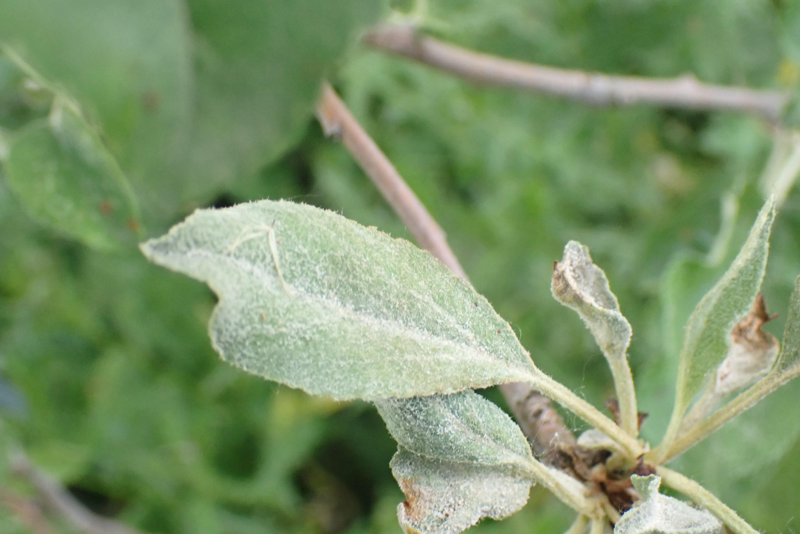

In [188]:
# Loading an image from the Validation/ Powdery directory
image_path = './datasets/plant-disease-recognition-dataset/Validation/Validation/Powdery/9b6a318cc5721d73.jpg'
original_image = Image.open(image_path)
og_width, og_height = original_image.size

# Resizing image for optimal performance
new_width = int(og_width * .20) # 20% of the original size
new_height = int(og_height * .20) # 20% of the original size

resized_img = original_image.resize((new_width, new_height))
print('Picture of a Powdery Plant: \n')
resized_img

In [193]:
from tensorflow.keras.preprocessing import image

# Charger l'image de validation
img_path = image_path  # Remplacer par le chemin de l'image
img = image.load_img(img_path, target_size=(224, 224))  # Redimensionner l'image à la taille 224x224 pixels

# Convertir l'image en tableau numpy
img_array = image.img_to_array(img)

# Ajouter une dimension supplémentaire pour simuler un batch de taille 1
img_array = np.expand_dims(img_array, axis=0)

# Normaliser les pixels entre 0 et 1 si nécessaire (comme dans ImageDataGenerator)
img_array = img_array / 255.0

# Faire la prédiction
predictions = model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


In [195]:

labels = ['Healthy', 'Powdery', 'Rust']

preds_class = np.argmax(predictions)
preds_label = labels[preds_class]

print(f'\nPredicted Class: {preds_label}')
print(f'\nConfidence Score: {preds[0][preds_class]}')


Predicted Class: Healthy

Confidence Score: 0.34202805161476135
